In [1]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2, FakeProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob
import pickle as pkl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC,  QRewindingRC_Neat
from src.data import DataSource

from iqm.qiskit_iqm import IQMFakeAdonis
from iqm.qiskit_iqm import IQMProvider,transpile_to_IQM

server_url = "https://cocos.resonance.meetiqm.com/garnet"  # For example https://cocos.resonance.meetiqm.com/garnet
api_token = "w8yFvWKCBEj26UGLs6H/OpoPgJtyzhT05Qj89TTyWXsGa9IttUZ494AAS29Z0Cju"

SHOTS = 8000

backend = IQMProvider(server_url, token=api_token).get_backend()

In [2]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              #'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              #'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':False, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'ridge', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits. #ACTUALLY, Not implemented!
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              #'file_name':'New_Class_Testing_no_x',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters


c_rseed=5
d_rseed=5000+5
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=d_rseed)

fulldict['rseed']=c_rseed
fulldict['use_true_y_in_val']=True
fulldict['shots']=8000



    
fulldict['file_name']='Final_Reservoir_Experiment_Simulated'

fulldict['confirm']=True
fulldict['simulate']=True




Simulated_Experiment= QRewindingRC_Neat(**fulldict)
#data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
Simulated_Experiment.prepare(data)

IQM
Using Hard-coded layout


In [3]:
Simulated_Experiment.train(resume=False)

transpiled circuits 0.975
saved circuits


In [4]:

SimDict={}
Simulated_Experiment.reinterpret_with_inputs()
Simulated_Experiment.mse_train
SimDict['train_w_R']=Simulated_Experiment.mse_train
Simulated_Experiment.val_with_inputs(resume=False)
Simulated_Experiment.mse_val
SimDict['val_w_R']=Simulated_Experiment.mse_val
Simulated_Experiment.reinterpret_only_inputs()
Simulated_Experiment.mse_train
SimDict['train_o_R']=Simulated_Experiment.mse_train
Simulated_Experiment.val_only_inputs(resume=False)
Simulated_Experiment.mse_val
SimDict['val_o_R']=Simulated_Experiment.mse_val


Loaded counts from file
Validation error == Train error: False. Relative difference: 0.6117476001242723
Loaded counts from file
Validation error == Train error: False. Relative difference: 0.40886783009755306


In [10]:
with open('Simulated_Results.pickle', 'wb') as handle:
    pkl.dump(SimDict, handle)

In [6]:
SimDict

{'train_w_R': 0.1557188338039383,
 'val_w_R': 0.250979456677648,
 'train_o_R': 0.1835132568544082,
 'val_o_R': 0.258545923978605}

In [3]:
fulldict['file_name']='Final_Reservoir_Experiment_Real'

fulldict['confirm']=True
fulldict['simulate']=False




Real_Experiment= QRewindingRC_Neat(**fulldict)
Real_Experiment.prepare(data)

IQM
Using Hard-coded layout


In [12]:
Real_Experiment.train(resume=False,wait=True,recheck=601)

transpiled circuits 0.975
saved circuits
Dealing with 7143 circuits, 2.041e+06 instructions, and 5.714e+07 total shots.
Created 66 batches!
Optimistic and approximate runtime: 57738.0 seconds
beginning first submission!
Waiting mode enabled: Will try to resubmit every 601 seconds
Using previous batch sizes
Created 66 batches!
Optimistic and approximate runtime: 57738.0 seconds
resuming on: [('CANCELLED', 0), ('DONE', 0), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 66), ('RUNNING', 0), ('VALIDATING', 0), ('UNSUBMITTED', 0)]
Using previous batch sizes, 0), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 66), ('RUNNING', 0), ('VALIDATING', 0), ('UNSUBMITTED', 0)]
Created 66 batches!
Optimistic and approximate runtime: 57738.0 seconds
resuming on: [('CANCELLED', 0), ('DONE', 0), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 66), ('RUNNING', 0), ('VALIDATING', 0), ('UNSUBMITTED', 0)]
Using previous batch sizes, 0), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 66), ('RUNNING', 0), ('VALIDAT

HTTPError: 429 Client Error: Too Many Requests for url: https://cocos.resonance.meetiqm.com/garnet/jobs/066d1c4f-7740-7d8c-8000-63723844bd59/status

In [4]:
Real_Experiment.train(resume=True,wait=True,recheck=1)

resuming on interpretation


In [5]:
RealDict={}
Real_Experiment.reinterpret_with_inputs()
Real_Experiment.mse_train
RealDict['train_w_R']=Simulated_Experiment.mse_train
#Simulated_Experiment.val_with_inputs(resume=False)
#Simulated_Experiment.mse_val
#SimDict['val_w_R']=Simulated_Experiment.mse_val
#Simulated_Experiment.reinterpret_only_inputs()
#Simulated_Experiment.mse_train
#SimDict['train_o_R']=Simulated_Experiment.mse_train
#Simulated_Experiment.val_only_inputs(resume=False)
#Simulated_Experiment.mse_val
#SimDict['val_o_R']=Simulated_Experiment.mse_val
with open('Real_Results.pickle', 'wb') as handle:
    pkl.dump(RealDict, handle)

Loaded counts from file


In [6]:
Real_Experiment.mse_train

0.15933542172033538

In [13]:
Real_Experiment.val_with_inputs(resume=False,wait=True,recheck=270)

Dealing with 45 circuits, 1.286e+04 instructions, and 3.600e+05 total shots.
Created 1 batches!
Optimistic and approximate runtime: 369.0 seconds
beginning first submission!
Waiting mode enabled: Will try to resubmit every 270 seconds
All batches finished; presenting final results in original list form
Dealing with 45 circuits, 1.286e+04 instructions, and 3.600e+05 total shots.
Created 1 batches!
Optimistic and approximate runtime: 369.0 seconds
beginning first submission!
Waiting mode enabled: Will try to resubmit every 270 seconds
All batches finished; presenting final results in original list form
Dealing with 45 circuits, 1.286e+04 instructions, and 3.600e+05 total shots.
Created 1 batches!
Optimistic and approximate runtime: 369.0 seconds
beginning first submission!
Waiting mode enabled: Will try to resubmit every 270 seconds
All batches finished; presenting final results in original list form
Dealing with 45 circuits, 1.286e+04 instructions, and 3.600e+05 total shots.
Created 1 b

In [7]:
from iqm.qiskit_iqm import IQMJob

In [8]:
job_test=IQMJob(backend,"066d61c4-d7f5-7549-8000-ac53447aef5b")

In [12]:
job_test.status().name=='DONE'

True

In [14]:
RealDict={}
#Real_Experiment.reinterpret_with_inputs()
Real_Experiment.mse_train
RealDict['train_w_R']=Real_Experiment.mse_train
#Simulated_Experiment.val_with_inputs(resume=False)
#Simulated_Experiment.mse_val
RealDict['val_w_R']=Real_Experiment.mse_val
#Simulated_Experiment.reinterpret_only_inputs()
#Simulated_Experiment.mse_train
#SimDict['train_o_R']=Simulated_Experiment.mse_train
#Simulated_Experiment.val_only_inputs(resume=False)
#Simulated_Experiment.mse_val
#SimDict['val_o_R']=Simulated_Experiment.mse_val
with open('Real_Results.pickle', 'wb') as handle:
    pkl.dump(RealDict, handle)

Loaded counts from file


In [17]:
Real_Experiment.mse_val

0.3099608155561443

MSE per episode
 [[ 4.          0.16301085]
 [ 0.          0.16452018]
 [ 5.          0.17004797]
 [ 2.          0.18169193]
 [ 8.          0.19356509]
 [ 7.          0.19966289]
 [ 9.          0.20863413]
 [ 3.          0.22258104]
 [14.          0.22498274]
 [11.          0.23132254]
 [ 1.          0.23499857]
 [ 6.          0.24915271]
 [13.          0.27388582]
 [12.          0.27994344]
 [10.          1.68598044]]


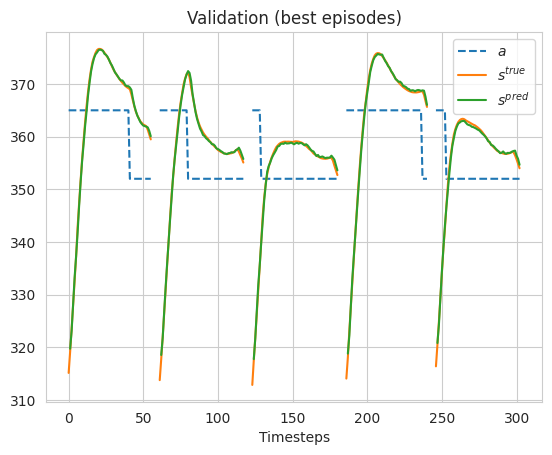

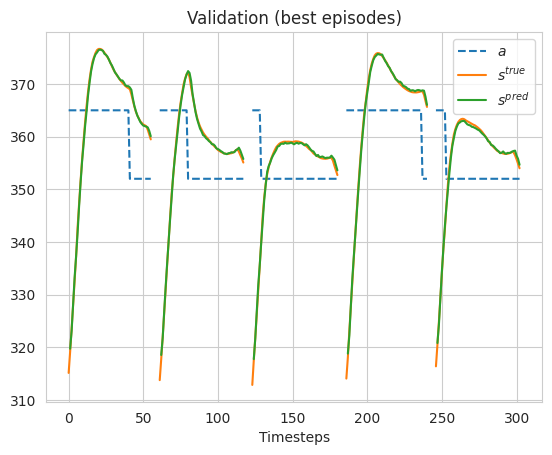

In [18]:
Real_Experiment.plot_best_val_episodes()

In [21]:
fulldict = Batch_Set_Parameters | Batch_Free_Parameters

for seed_v in range(5):
    c_rseed=seed_v
    d_rseed=5000+seed_v
    data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=d_rseed)

    fulldict['rseed']=c_rseed
    fulldict['use_true_y_in_val']=True
    fulldict['shots']=8000



        
    fulldict['file_name']='Final_Reservoir_Experiment_Simulated'+str(seed_v)

    fulldict['file_name']='Final_Reservoir_Experiment_Real'+str(seed_v)

    fulldict['confirm']=False
    fulldict['simulate']=False

    print('Simulated %s Done' % seed_v)


    Real_Experiment= QRewindingRC_Neat(**fulldict)
    Real_Experiment.prepare(data)

    Real_Experiment.train(resume=True,wait=True,recheck=601)

    RealDict={}
    Real_Experiment.reinterpret_with_inputs()
    Real_Experiment.mse_train
    RealDict['train_w_R']=Simulated_Experiment.mse_train
    #Simulated_Experiment.val_with_inputs(resume=False)
    #Simulated_Experiment.mse_val
    #SimDict['val_w_R']=Simulated_Experiment.mse_val
    #Simulated_Experiment.reinterpret_only_inputs()
    #Simulated_Experiment.mse_train
    #SimDict['train_o_R']=Simulated_Experiment.mse_train
    #Simulated_Experiment.val_only_inputs(resume=False)
    #Simulated_Experiment.mse_val
    #SimDict['val_o_R']=Simulated_Experiment.mse_val
    with open('Real_Results_%s.pickle' % seed_v, 'wb') as handle:
        pkl.dump(RealDict, handle)

    print('Real Train %s Done' % seed_v)

    Real_Experiment.val_with_inputs(resume=False,wait=True,recheck=270)
    
    RealDict['val_w_R']=Real_Experiment.mse_val

    with open('Real_Results_%s.pickle' % seed_v, 'wb') as handle:
        pkl.dump(RealDict, handle)

    print('Real Val %s Done' % seed_v)
    
    

Simulated 0 Done
IQM
Using Hard-coded layout
resuming on defining circuits
transpiled circuits 0.975
saved circuits
Dealing with 7191 circuits, 2.054e+06 instructions, and 5.753e+07 total shots.
Created 66 batches!
Optimistic and approximate runtime: 58122.0 seconds
beginning first submission!
Waiting mode enabled: Will try to resubmit every 601 seconds
Using previous batch sizes
Created 66 batches!
Optimistic and approximate runtime: 58122.0 seconds
resuming on: [('CANCELLED', 0), ('DONE', 2), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 63), ('RUNNING', 1), ('VALIDATING', 0), ('UNSUBMITTED', 0)]
Using previous batch sizes, 2), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 63), ('RUNNING', 1), ('VALIDATING', 0), ('UNSUBMITTED', 0)]
Created 66 batches!
Optimistic and approximate runtime: 58122.0 seconds
resuming on: [('CANCELLED', 0), ('DONE', 2), ('ERROR', 0), ('INITIALIZING', 0), ('QUEUED', 62), ('RUNNING', 2), ('VALIDATING', 0), ('UNSUBMITTED', 0)]
Using previous batch sizes, 2), (

HTTPError: 429 Client Error: Too Many Requests for url: https://cocos.resonance.meetiqm.com/garnet/jobs/066db247-1142-78fd-8000-1993fcb39536/status

In [ ]:

    fulldict['confirm']=False
    fulldict['simulate']=True




    Simulated_Experiment= QRewindingRC_Neat(**fulldict)
    #data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
    Simulated_Experiment.prepare(data)

    Simulated_Experiment.train(resume=False)

    SimDict={}
    Simulated_Experiment.reinterpret_with_inputs()
    Simulated_Experiment.mse_train
    SimDict['train_w_R']=Simulated_Experiment.mse_train
    Simulated_Experiment.val_with_inputs(resume=False)
    Simulated_Experiment.mse_val
    SimDict['val_w_R']=Simulated_Experiment.mse_val
    Simulated_Experiment.reinterpret_only_inputs()
    Simulated_Experiment.mse_train
    SimDict['train_o_R']=Simulated_Experiment.mse_train
    Simulated_Experiment.val_only_inputs(resume=False)
    Simulated_Experiment.mse_val
    SimDict['val_o_R']=Simulated_Experiment.mse_val

    with open('Simulated_Results_%s.pickle' % seed_v, 'wb') as handle:
        pkl.dump(SimDict, handle)


In [22]:
with open('Real_Results_0.pickle', 'rb') as handle:
    dict_0=pkl.load(handle)

In [23]:
dict_0.keys()

dict_keys(['train_w_R', 'val_w_R'])

In [24]:
dict_0

{'train_w_R': 0.17591081573655254, 'val_w_R': 0.2643083540231406}

In [25]:
with open('Simulated_Results_0.pickle', 'rb') as handle:
    Sdict_0=pkl.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: 'Simulated_Results_0.pickle'

In [3]:
Batch_Set_Parameters = {'reset_instead_meas':False, # whether to reset or measure data qubits. Not relevant due to architecture.
                             'mend':False, # not used by this architecture.
                              'add_y_to_input':True, # In our experiment, this means use previous temperatures to predict future steps.
                              'mtype':'projection', # weak measurements are not supported.
                              'minc':True, # not used by this architecture.
                              'reseti':False, #reset before measurement. Not possible for us.
                              'resetm':False, #reset after measurement. Not relevant for us.
                              'xyoffset':1, # Use x_t, y_(t-1). Necessary for reactor data.

                              #Not used for real backend:
                              'sim':'aer_simulator', 
                              't1':50, 
                              'sim_method':'statevector', 
                              'sim_precision':'single',
                              'strip_metadata' : False,
                              'initial_layout' : None,
                              'verbose' : True

                              
                              
                              








                             
                             }

Batch_Free_Parameters = {'use_partial_meas':True, # determines whether measurement results from previous steps are used as features.
                              'lookback':4, # Number of previous time steps to be used
                              'restarting':False, # If true, uses all previous time steps.
                              'lookback_max':False, #If true AND restarting is false, will add time steps before t=0 for ensure lookback. CHECK!
                              'washout':0, # Ignore the first <washout> steps when fitting.
                              'preloading':0, # Repeat the first step <PREDLOADING> times in data.
                              'nmeas':2, # How many measurements are made after each rewind step. Only relevant when using partial measurements.
                              'nenccopies':1, #Number of times each data point is entered. Requires more qubits for each repetition. 
                              'set_past_y_to_0':False, #If true, t<0 steps are set to 0.
                              #'use_true_y_in_val':False, # If false, Rollout predictions are performed.
                              #'rseed':0, # Random seed used to choose parameters.
                              'log':True, # Save the results of the run. 
                              'add_x_as_feature':False, #Use x directly as a feature as well as circuit results.
                              'nyfuture':1, #How many steps in the future to predict. Only the next step is used for eval.
                               'delete_future_y':True, #If predicting multiple future steps, if no step exists, delete (True) or duplicate last (False).
                                'fitter':'sklearn_poly', # set to sklearn_poly for higher order fits.
                                'regression_model':'ridge', #Options: ‘ridge’, ‘lasso’, ‘elasticnet’, ‘linear’.
                                'regression_alpha':0.1, # Regularization parameter for ridge, lasso, elasticnet.
                                'regression_l1':0.1, #L1 ratio for elasticnet.
                                'poly_degree':3, #degree of sklearn_poly polynomial fits. #ACTUALLY, Not implemented!
                                'nqubits':5, #Number of qubits for a single Unitary step.
                                'qctype':'ising_hadamard', # unitary choice. 
                                'qinit':'none', #perform an initial step.
                                'ftype':3, #N Body correllations to measure.
                                'nlayers':1, # How many times the unitary is applied at each step.'
                              'enctype':'angle', #How to input data into the circuits.
                              'encaxes':1, #How many times to encode the data.
                              'measaxes':3, #Number of different Pauli basis to measure.
                              'shots':8192,
                              'ising_t':1, 
                              'ising_jmax':1, 
                              'ising_h':0.1, 
                              'ising_wmax':10, 
                              'ising_random':True, 
                              'ising_jpositive':False, 
                              'ising_wpositive':False,
                              'sim':backend, 
                              #'file_name':'New_Class_Testing_no_x',
                              'max_batch': 31250, #All relate to the batch code from Alessio.
                              'max_tries' : 10,
                              'max_circuit' : 1000,
                              'verbose': True,
                              'calibration_set_id' : None,
                              'qubits':None,
                              'reduced_coupling_map':None,
                              'initial_layout':None,
                              'total_req':19,
                              'max_concurrent': 100,
                              'simulate': True,
                              'manual': True

                          


}
fulldict = Batch_Set_Parameters | Batch_Free_Parameters

seed_v = 0 
c_rseed=seed_v
d_rseed=5000+seed_v
data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=d_rseed)

fulldict['rseed']=c_rseed
fulldict['use_true_y_in_val']=True
fulldict['shots']=8000



    
fulldict['file_name']='Final_Reservoir_Experiment_Simulated0'

fulldict['confirm']=True
fulldict['simulate']=True




Simulated_Experiment= QRewindingRC_Neat(**fulldict)
#data = DataSource(xtype='reactor', ytype='reactor', xnorm='norm', ynorm='norm', rseed_data=9369)
Simulated_Experiment.prepare(data)

IQM
Using Hard-coded layout


In [4]:
Simulated_Experiment.train(resume=False)
SimDict={}

Simulated_Experiment.reinterpret_only_inputs()
Simulated_Experiment.mse_train
SimDict['train_o_R']=Simulated_Experiment.mse_train
Simulated_Experiment.val_only_inputs(resume=False)
Simulated_Experiment.mse_val
SimDict['val_o_R']=Simulated_Experiment.mse_val

Simulated_Experiment.reinterpret_with_inputs()
Simulated_Experiment.mse_train
SimDict['train_w_R']=Simulated_Experiment.mse_train
Simulated_Experiment.val_with_inputs(resume=False)
Simulated_Experiment.mse_val
SimDict['val_w_R']=Simulated_Experiment.mse_val

with open('Simulated_Results_0.pickle', 'wb') as handle:
    pkl.dump(SimDict, handle)

transpiled circuits 0.975
saved circuits
Loaded counts from file
Validation error == Train error: False. Relative difference: 0.5357639423367188
Loaded counts from file
Validation error == Train error: False. Relative difference: 0.6758639492615683


MSE per episode
 [[ 9.          1.64792069]
 [ 7.          0.23882925]
 [ 6.          0.22130193]
 [ 4.          0.20454907]
 [13.          0.19891587]
 [ 0.          0.19292954]
 [ 3.          0.18427414]
 [12.          0.17699089]
 [ 8.          0.17097914]
 [10.          0.17017006]
 [ 1.          0.1549596 ]
 [14.          0.1412682 ]
 [ 2.          0.14114716]
 [11.          0.11462121]
 [ 5.          0.09602489]]


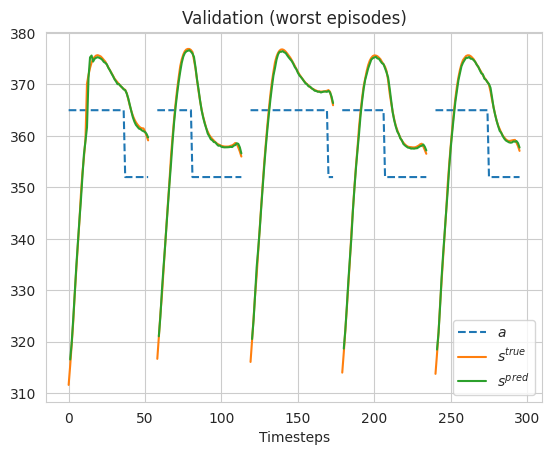

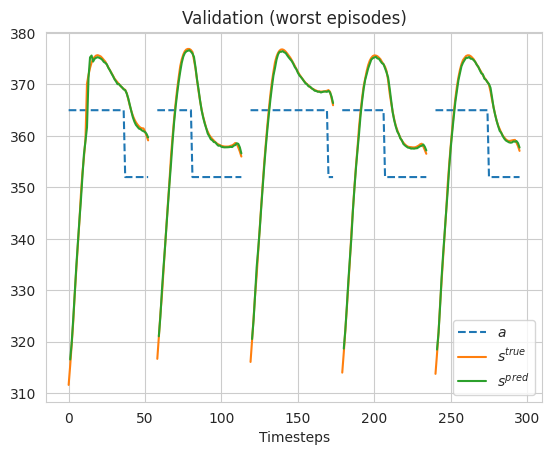

In [5]:
Simulated_Experiment.plot_worst_val_episodes()

In [7]:
len(Simulated_Experiment.data.xval)

15